# Anomaly Detection

### Load Data

First we will load the data using a pickle format. (We use ```import cPickle as pickle``` because cPickle is faster.)

The data we use contains the pageviews of one of our own websites and for convenience there is only 1 data point per hour.

In [1]:
import cPickle as pickle

past = pickle.load(open('data/past_data.pickle'))
all_data = pickle.load(open('data/all_data.pickle'))

### Plot past data

To plot the past data we will use matplotlib.pyplot. It was imported as plt.

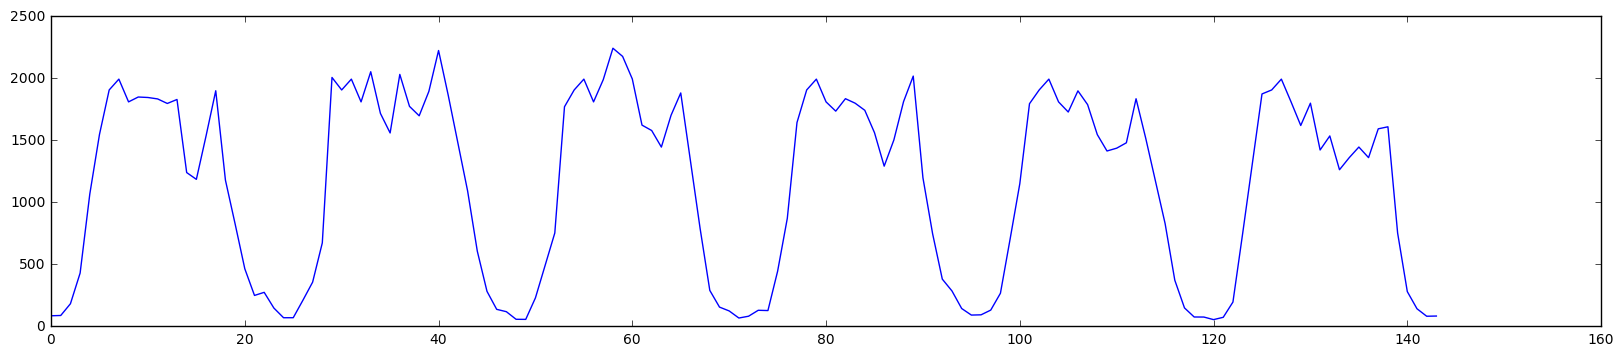

In [14]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20,4)) # This creates a new figure with the dimensions of 20 by 4
plt.plot(past)             # This creates the actual plot
plt.show()                 # This shows the plot

### Find the minimum and maximum

Use [```np.nanmax()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmax.html#numpy.nanmax) and [```np.nanmin()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmin.html) to find the minmum and maximum while ignoring the NaNs.

In [3]:
import numpy as np

maximum = np.nanmax(past)
minimum = np.nanmin(past)

And plot these together with the data using the axhline function.

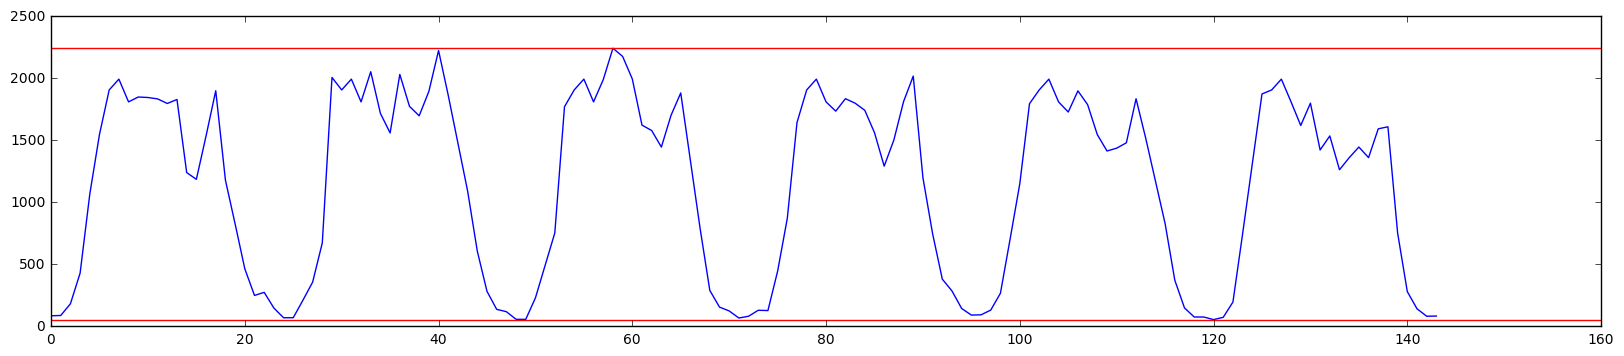

In [4]:
plt.figure(figsize=(20,4))
plt.plot(past)
plt.axhline(maximum, color='r')
plt.axhline(minimum, color='r')
plt.show()

### Testing the model on unseen data

Now plot all the data instead of just the past data

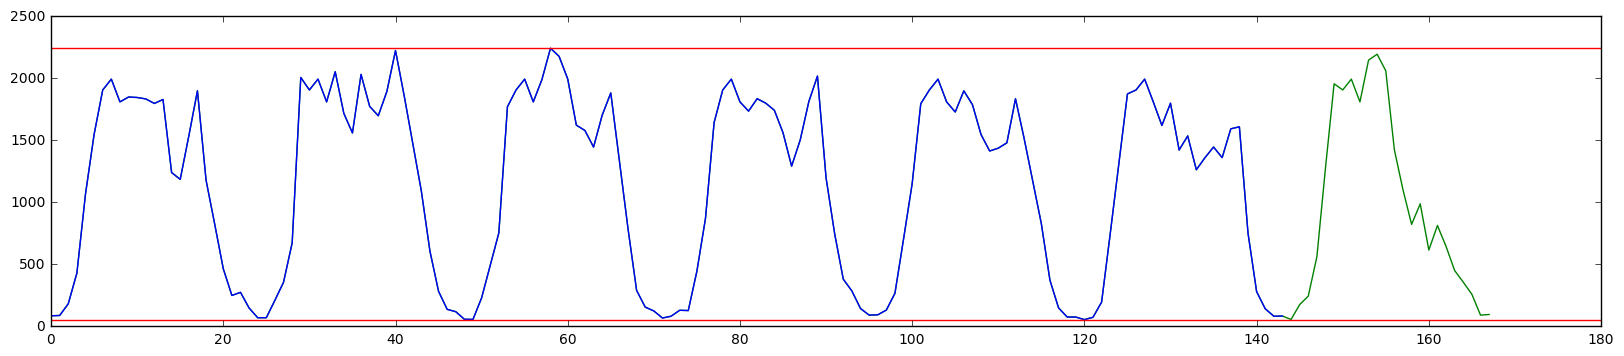

In [5]:
plt.figure(figsize=(20,4))
plt.plot(all_data, color='g')
plt.plot(past, color='b')
plt.axhline(maximum, color='r')
plt.axhline(minimum, color='r')
plt.show()

You can clearly see now  that this model does not detect any anomalies. However, the last day of data clearly looks different compared to the other days.

In what follows we will build a better model for anomaly detection that is able to detect these 'shape shifts' as well.

### Building a model with seasonality

To do this we are going to take a step by step approach. Maybe it won't be clear at first why every step is necessary, but that will become clear throughout the process.

First we are going to reshape the past data to a 2 dimensional array with 24 elements in the second row. For this we are going to use the [```np.reshape()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) function. The newshape parameter is a tuple which in this case should be ```(-1, 24)```. If you use a ```-1``` the reshape function will automatically compute that dimension.

In [6]:
reshaped_past = past.reshape((-1, 24))

Now we are going to compute the average over all days. For this we are going to use the [```np.mean()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html) with the axis variable set to the first dimension (```axis=0```). Next we are going to plot this.

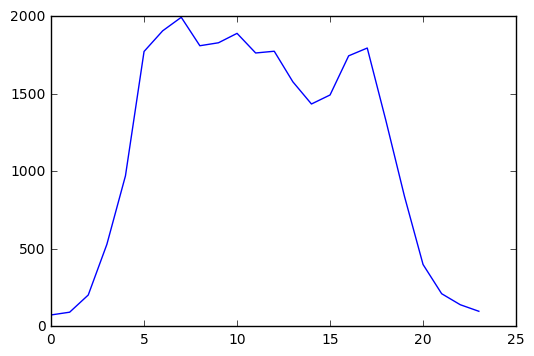

In [7]:
average_past = np.mean(reshaped_past, axis=0)

plt.plot(average_past)
plt.show()

What you can see in the plot above is the average number of pageviews for eacht hour of the day.

Now let's plot this together with the past data on 1 plot. Use the [```np.concatenate()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) function to concatenate this average 6 times.

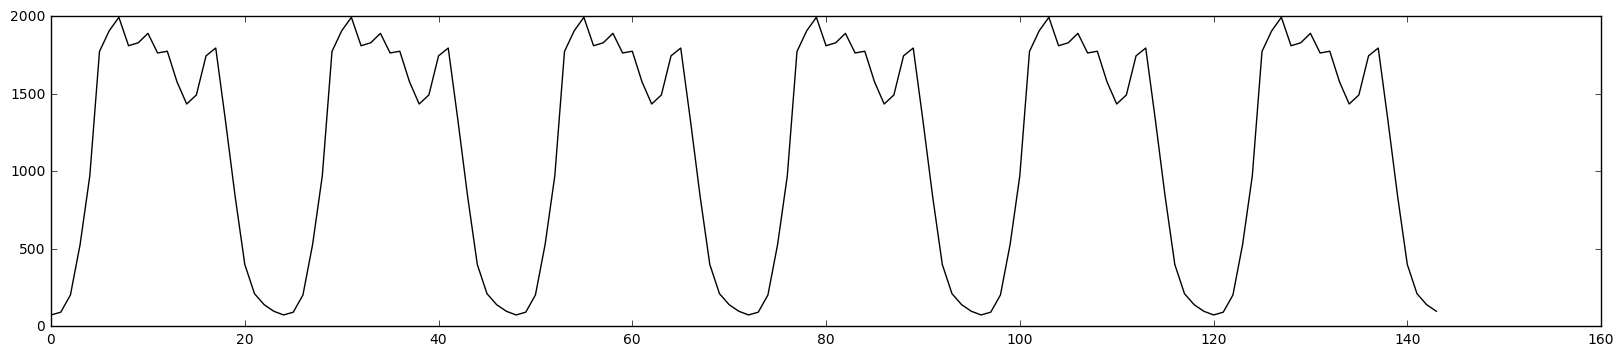

In [8]:
model = []
for i in range(6):
    model = np.concatenate((model, average_past))
plt.figure(figsize=(20,4))    
plt.plot(model, color='k')
plt.show()

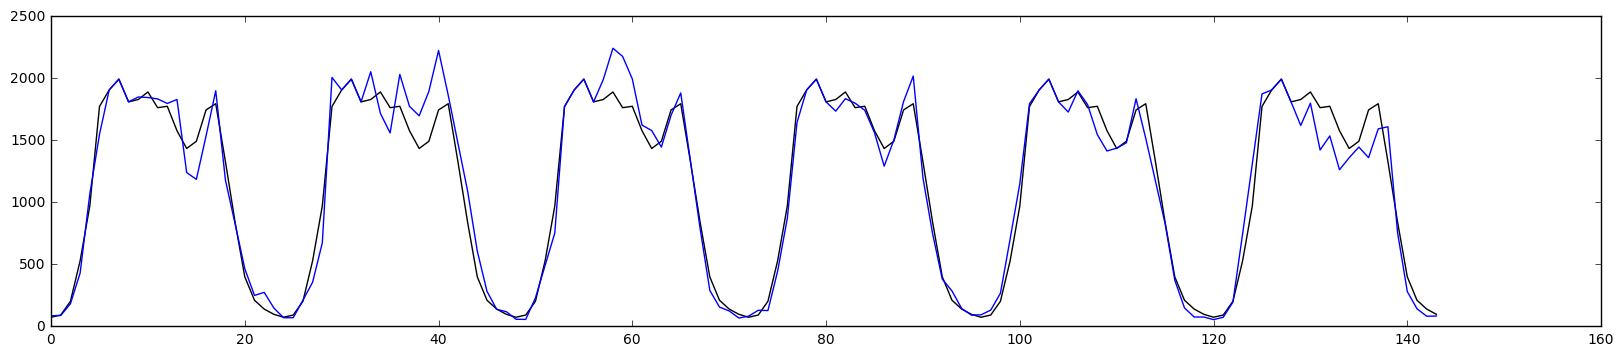

In [9]:
plt.figure(figsize=(20,4))
plt.plot(model, color='k')
plt.plot(past, color='b')
plt.show()

In the next step we are going to compute the maximum and minimum deviations from the average to determine what kind of deviations are normal. (Just substract the average from the past and take the min and the max of that)

In [10]:
delta_max = np.nanmax(past - model)
delta_min = np.nanmin(past - model)

Now let's plot this.

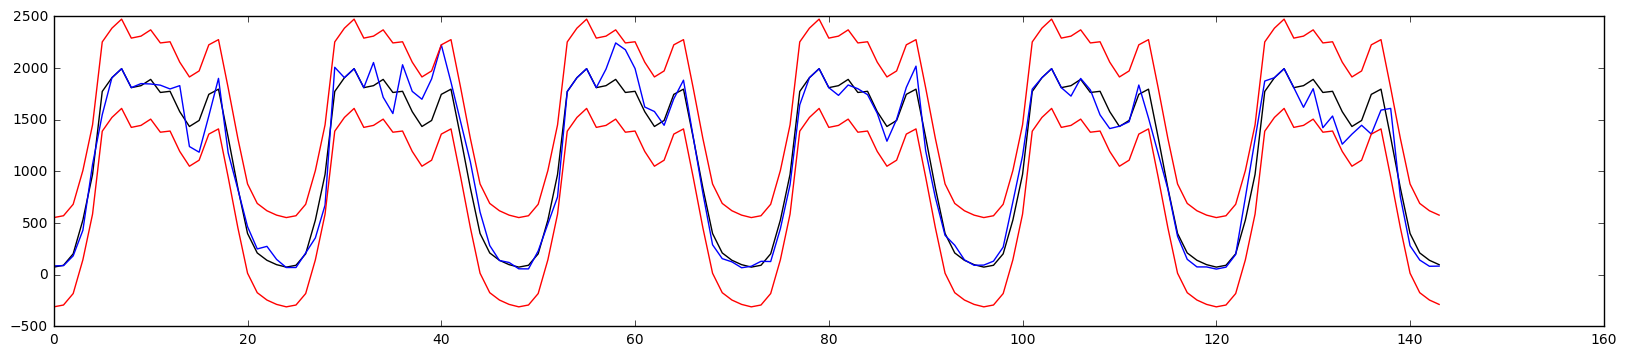

In [11]:
plt.figure(figsize=(20,4))
plt.plot(model, color='k')
plt.plot(past, color='b')
plt.plot(model + delta_max, color='r')
plt.plot(model + delta_min, color='r')
plt.show()

Now let's test this on all data

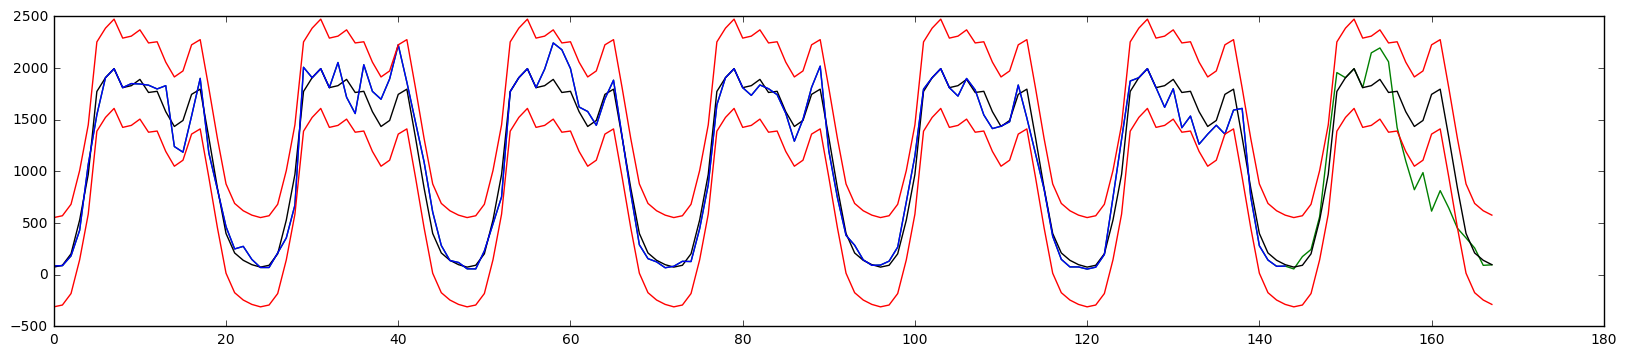

In [12]:
model_all = np.concatenate((model, average_past))

plt.figure(figsize=(20,4))
plt.plot(all_data, color='g')
plt.plot(model_all, color='k')
plt.plot(past, color='b')
plt.plot(model_all + delta_max, color='r')
plt.plot(model_all + delta_min, color='r')
plt.show()

Now you can clearly see where the anomaly is detected by this more advanced model. The code below can gives you the exact indices where an anomaly is detected. The functions uses are the following [```np.where()```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) and [```np.logical_or()```](http://docs.scipy.org/doc/numpy/reference/generated/numpy.logical_or.html).

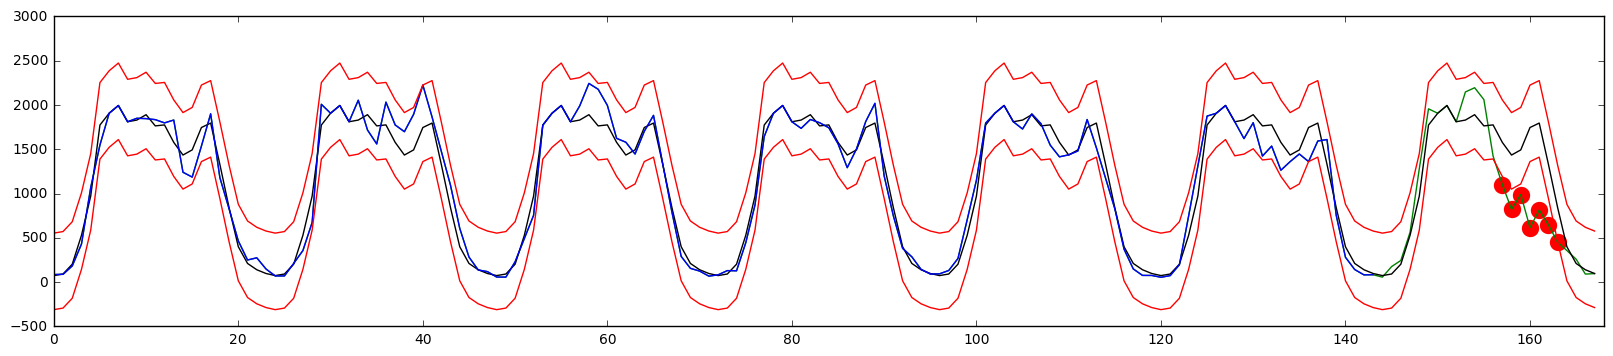

The anomaly occurs at the following timestamps: [157 158 159 160 161 162 163]


In [23]:
anomaly_timepoints = np.where(np.logical_or(all_data < model_all + delta_min, all_data > model_all + delta_max))[0]

plt.figure(figsize=(20,4))
plt.scatter(anomaly_timepoints, all_data[anomaly_timepoints], color='r', linewidth=8)
plt.plot(all_data, color='g')
plt.plot(model_all, color='k')
plt.plot(past, color='b')
plt.plot(model_all + delta_max, color='r')
plt.plot(model_all + delta_min, color='r')
plt.xlim(0, len(all_data))
plt.show()

print 'The anomaly occurs at the following timestamps:', anomaly_timepoints

## Forecasting

For the forecasting we are going to use page views data, very similar to the data used in the anomaly detection section. It also contains 1 sample per hour. 

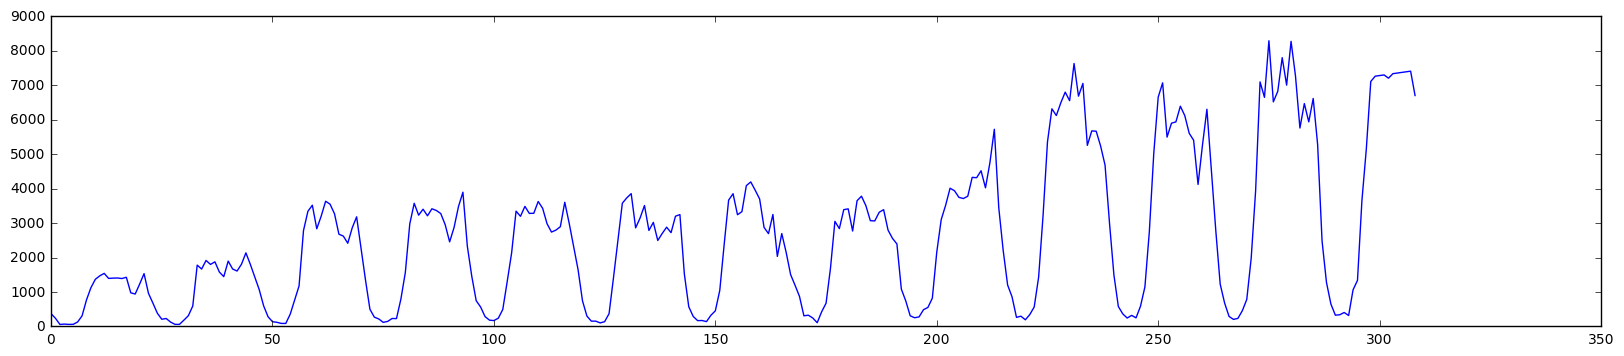

In [466]:
train_set = pickle.load(open('data/train_set_forecasting.pickle'))

plt.figure(figsize=(20,4))
plt.plot(train_set)
plt.show()

In the graph above you can clearly see that there is a rising trend in the data.

### One-step ahead prediction

This forecasting section will describe the one-step ahead prediction. This means in this case that we will only predict the data point which is in this case the number of pageviews in the next hour.

To predict the datapoint after that we will use the predicted data to make a new prediction. The code below shows how this works for this data set using the linear model you used earlier.

In [493]:
model = sklearn.linear_model.LinearRegression()


X = train_set[ : -1].reshape((-1, 1))
y = train_set[1 : ]

model.fit(X, y)

# this score gives you how well it fits on the train set
# higher is better and 1.0 is perfect
print 'The score of the linear model is', model.score(X, y)

The score of the linear model is 0.886880698418


As you can see from the score above, the model is not perfect but it seems to get a relatively high score. Now let's make a prediction into the future and plot this.

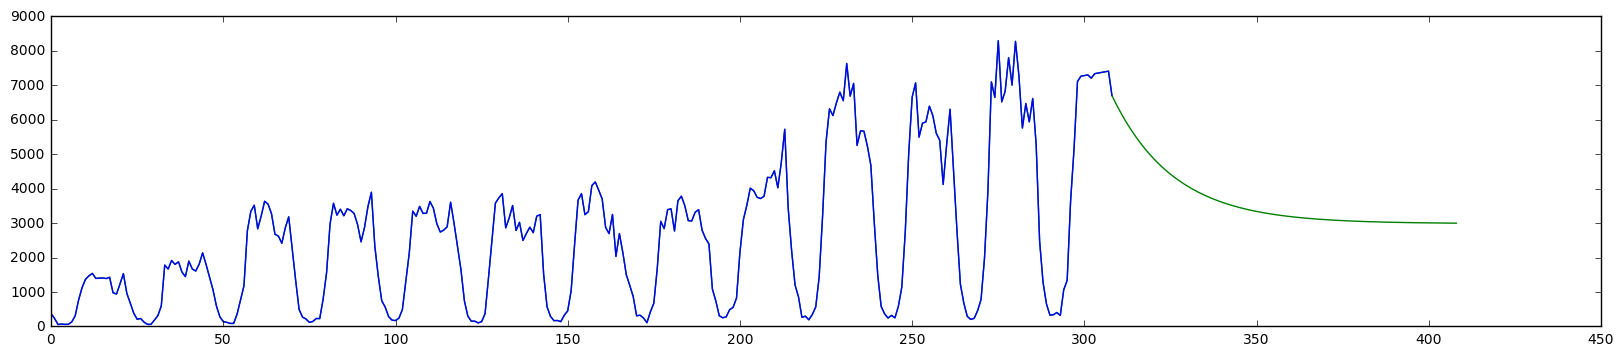

In [497]:
nof_predictions = 100

import copy
x_test = copy.deepcopy(train_set[-1]) # make a copy to avoid overwriting the training data

prediction = []
for i in range(nof_predictions):
    y_test = model.predict(x_test.reshape((1,1)))
    prediction.append(y_test)
    x_test = y_test
    
prediction = np.array(prediction)

plt.figure(figsize=(20,4))
plt.plot(np.concatenate((train_set, prediction[:,0])), 'g')
plt.plot(train_set, 'b')
plt.show()

As you can see from the image above the model doesn't quite seem to fit the data well. Let's see how we can improve this.

### Multiple features

If you model is not smart enough there is a simple trick in machine learning to make your model more intelligent (but also more complex). This is by adding more features.

To make our model better we will use more than 1 sample from the past. To make your life easier there is a simple function below that will create a data set for you. The ```width``` parameter sets the number of hours in the past that will be used.

In [498]:
def convert_time_series_to_Xy(ts, width):
    X, y = [], []
    for i in range(len(ts) - width - 1):
        X.append(ts[i : i + width])
        y.append(ts[i + width])
    return np.array(X), np.array(y)

In [499]:
width = 5
X, y = convert_time_series_to_Xy(train_set, width)

print X.shape, y.shape

(303, 5) (303,)


As you can see from the print above both X and y contains 303 datapoints. For X you see that there are now 5 features which contain the pageviews from the 5 past hours.

So let's have a look what the increase from 1 to 5 features results to.

In [504]:
width = 154
X, y = convert_time_series_to_Xy(train_set, width)
model = sklearn.linear_model.LinearRegression()
model.fit(X,y)
print 'The score of the linear model with widht =', width, 'is', model.score(X, y)

The score of the linear model with widht = 154 is 1.0


Now change the ```width``` parameter to see if you can get a better score.

### Over-fitting

Now execute the code below to see the prediction of this model.

In [507]:
# this is a helper function to make the predictions
def predict(model, train_set, width, nof_points):
    prediction = []
    # create the input data set for the first predicted output
    # copy the data to make sure the orriginal is not overwritten
    x_test = copy.deepcopy(train_set[-width : ]) 
    for i in range(nof_points):
        # predict only the next data point
        prediction.append(model.predict(x_test.reshape((1, -1))))
        # use the newly predicted data point as input for the next prediction
        x_test[0 : -1] = x_test[1 : ]
        x_test[-1] = prediction[-1]
    return np.array(prediction)

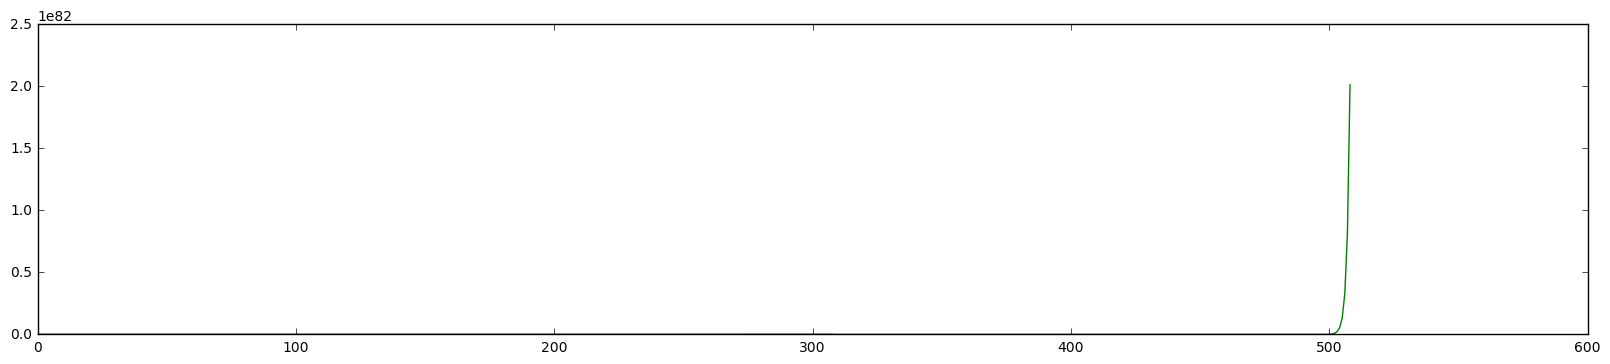

In [506]:
prediction = predict(model, train_set, width, 200)

plt.figure(figsize=(20,4))
plt.plot(np.concatenate((train_set, prediction[:,0])), 'g')
plt.plot(train_set, 'b')
plt.show()

As you can see in the image above the prediction is not what you would expect from a perfect model. What happened is that the model learned the training data by hart without 'understanding' what the data is really about. This fenomenon is called over-fitted and will always occur if you make your model more complex.

Now play with the number again to see if you can find a more sensible width.

The score of the linear model with widht = 24 is 0.956356591523


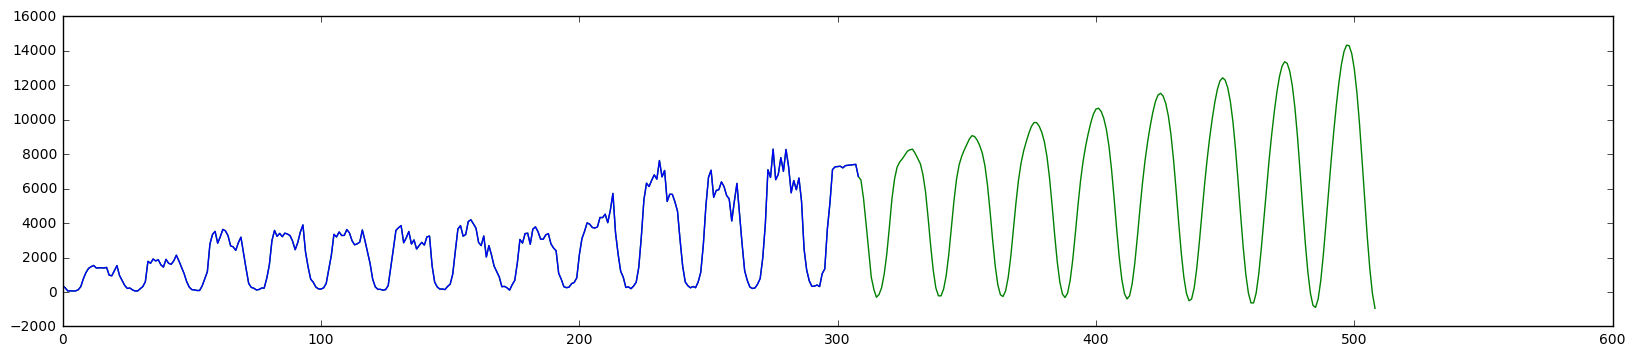

In [508]:
width = 24
X, y = convert_time_series_to_Xy(train_set, width)
model = sklearn.linear_model.LinearRegression()
model.fit(X,y)
print 'The score of the linear model with widht =', width, 'is', model.score(X, y)

prediction = predict(model, train_set, width, 200)

plt.figure(figsize=(20,4))
plt.plot(np.concatenate((train_set, prediction[:,0])), 'g')
plt.plot(train_set, 'b')
plt.show()

As you will have noticed by now is that it is better to have a non-perfect score which will give you a much better outcome. Now try the same thing for the following models:
* ```sklearn.linear_model.RidgeCV()```
* ```sklearn.linear_model.LassoCV()```
* ```sklearn.gaussian_process.GaussianProcess()```

The first 2 models also estimate the noise that is present in the data to avoid overfitting. ```RidgeCV``` will keep the weights that are found small, but it won't put them to zero. ```LassoCV``` on the other hand will put several weights to 0. Execute ```model.coef_``` to see the actual coefficients that have been found.

```GaussianProcess``` is a non-linear method. This makes this method a lot more complex and therefore it will need significantly less features to be able to learn the data by hart (and thus to over-fit). In many cases however this additional complexity allows to better understand the data. Additionally it has the advantage that it can estimate confidance intervals similar to the red lines used in the anomaly detection.

### Automation

What we have done up to now is manually selecting the best outcome based on the test result. This can be considered cheating because you have just created a self-fulfilling profecy. Additionally it is not only cheating it is also hard to find the exact ```width``` that gives the best result by just visually inspecting it. So we need a more objective approach to solve this.

To automate this process you can use a validation set. In this case we will use the last 48 hours of the training set to validate the score and select the best parameter value. This means that we will have to use a subset of the training set to fit the model.

In [532]:
model_generators = [sklearn.linear_model.LinearRegression, sklearn.linear_model.RidgeCV,
                    sklearn.linear_model.LassoCV, sklearn.gaussian_process.GaussianProcess]
best_score = 0

for model_gen in model_generators:
    for width in range(1, 200):
        X, y = convert_time_series_to_Xy(train_set, width)
        X_train, y_train = X[ : -48, :], y[ : -48]
        X_val, y_val = X[-48 : ], y[-48 : ]
        model = model_gen()
        try:
            model.fit(X_train, y_train)
            this_score = model.score(X_val, y_val)

            if this_score > best_score:
                best_score = this_score
                best_model_gen = model_gen
                best_width = width
        except:
            pass

print best_model_gen().__class__, 'was selted as the best model with a widht of', best_width, 'and a validation score of', best_score

<class 'sklearn.linear_model.coordinate_descent.LassoCV'> was selted as the best model with a widht of 26 and a validation score of 0.946563194695


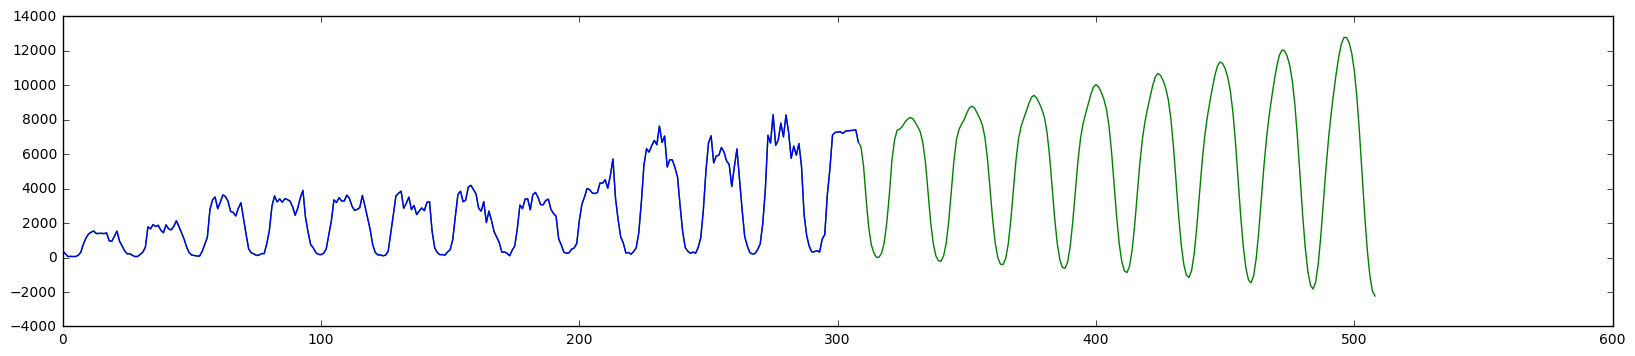

In [522]:
width = best_width
X, y = convert_time_series_to_Xy(train_set, width)
model = best_model_gen()
model.fit(X,y)
prediction = predict(model, train_set, width, 200)

plt.figure(figsize=(20,4))
plt.plot(np.concatenate((train_set, prediction[:,0])), 'g')
plt.plot(train_set, 'b')
plt.show()

Altough the optimal result found here might not be the best visually, it is a far better result than the one you selected manually just because there was no cheating involved ;-).

Some additional info:
* This noise level of ```RidgeCV``` and ```LassoCV``` is estimated by automatically performing train and validation within the method itself. This will make them much more robust against over-fitting. The actual method used is [Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) which is a better approach of what we do here because it repeats the training and validation multiple times for different training and validation sets. The parameter that is set for these methods is called the regularization parameter in literature.
* Although sklearn supports estimating the noice level in Gaussian Processes it is not implemented within the method itself. Newer versions of sklearn seem to entail a lot of changes in this method so possibly it will be integrated in the (near) future. If you want to implement this noise level estimation yourself you can use [their cross-validation tool](http://scikit-learn.org/stable/modules/cross_validation.html) to set the [```alpha``` parameter](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor) in version 0.18 of sklearn.

## Competition

@BART mijn inspriratie is op...